In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import os

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import seaborn as sns
import pprint
import operator
import time
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder

from utils.constants import PATH_DATA_CUST, PATH_DATA_AZD
from utils.helper import missing_summary, display_side_by_side
from utils import (read_data,
                   listtodict,
                  codetonan,
                  get_unknown,
                  encode_df,
                  cleanDf)

from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.preprocessing import Imputer
import xgboost as xgb
from xgboost import XGBClassifier
from category_encoders.cat_boost import CatBoostEncoder
from imblearn.over_sampling import SMOTE

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; i

In [2]:
test_fpath = '../../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv'
train_fpath = '../../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv'
col_to_drop = 'col_unused.txt'

with open(col_to_drop) as f:
    to_drop = f.read().splitlines() 

## Loading Data

In [3]:
def load_mail_data(mail_path=train_fpath):
    return pd.read_csv(mail_path, sep=';')

In [4]:
mailout_train = load_mail_data(train_fpath)
print(f'Shape of Training file: {mailout_train.shape}')
display(mailout_train.head(5))

Shape of Training file: (42962, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [5]:
mailout_test =load_mail_data(test_fpath)

In [6]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


split the train file into train, test file

In [6]:
#from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(mailout_train, test_size=.2, random_state=42)

In [7]:
##short cut to cleaned data
"""
cleaned_train=cleanDf(train_set, to_drop, 90)
X_train = cleaned_train.drop('RESPONSE', axis=1)
y_train = cleaned_train['RESPONSE']
"""

In [73]:
unknown_code = get_unknown()
codetonan(train_set, unknown_code)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Total execution time of this procedure: 21.22 seconds


# new proprocessing

drop rows with large amount of missing values, threshold 20

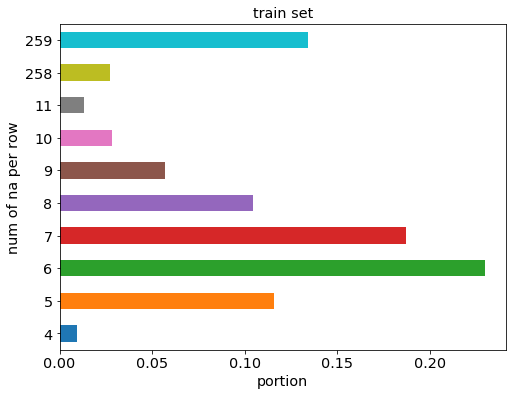

In [13]:
plt.figure(figsize=(8, 6))
na_row = train_set.isnull().sum(axis=1)
na_rowpp = na_row.value_counts(normalize=True)
ax = na_rowpp.head(10).sort_index().plot.barh()
ax.set(xlabel='portion', ylabel='num of na per row', title='train set');

In [74]:
mask_info = na_row <= 20
high_info = train_set[mask_info]
low_info = train_set[~mask_info]
print(f'Shape of High Informative train Group: {high_info.shape}')
print(f'Shape of Low Informative train Group: {low_info.shape}')

Shape of High Informative train Group: (26570, 367)
Shape of Low Informative train Group: (7799, 367)


In [15]:
high_info['RESPONSE'].value_counts()

0    26250
1      320
Name: RESPONSE, dtype: int64

In [16]:
low_info['RESPONSE'].value_counts()

0    7708
1      91
Name: RESPONSE, dtype: int64

Note: for those rows with high missing values, there are 91 individiduals repond to the campaign. What are their common features?

In [24]:
missing_summary(low_info).tail(20)

,counts,portion,Level.of.na
D19_TELKO_ANZ_12,0,0.0,Zero
D19_TELKO_ANZ_24,0,0.0,Zero
D19_TELKO_DATUM,0,0.0,Zero
D19_TELKO_MOBILE,0,0.0,Zero
D19_TELKO_OFFLINE_DATUM,0,0.0,Zero
D19_TELKO_REST,0,0.0,Zero
D19_VERSICHERUNGEN,0,0.0,Zero
D19_TIERARTIKEL,0,0.0,Zero
D19_VERSAND_ANZ_12,0,0.0,Zero
D19_VERSAND_ANZ_24,0,0.0,Zero


In [13]:
mask = low_info['RESPONSE']==1
low_yes = low_info[mask]
low_no = low_info[~mask]

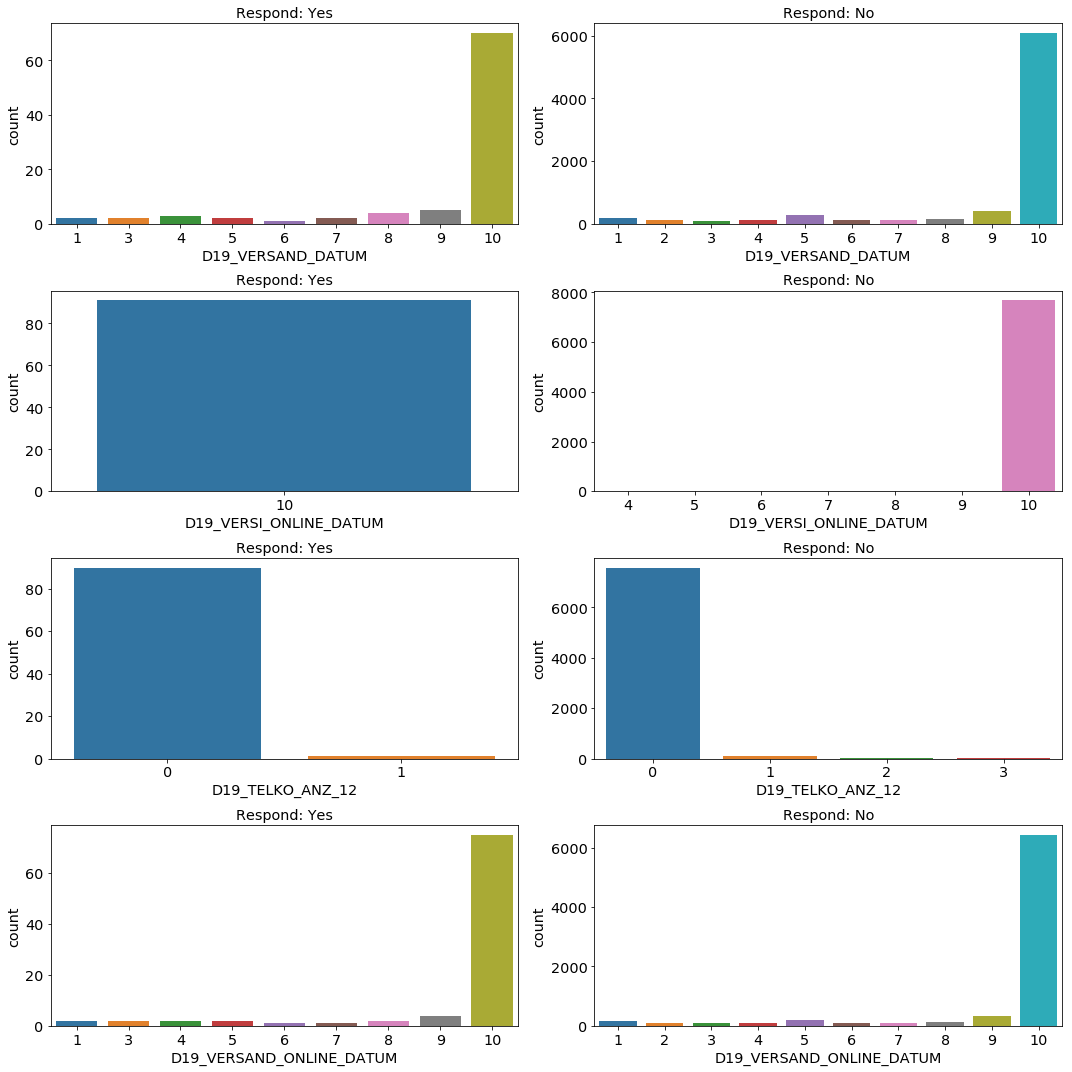

In [34]:
cols = ['D19_VERSAND_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_TELKO_ANZ_12', 'D19_VERSAND_ONLINE_DATUM']

n = len(cols)
fig, axes = plt.subplots(n, 2, figsize=(15, 15))

for i in range(n):
    sns.countplot(low_yes[cols[i]], ax=axes[i, 0])
    axes[i, 0].set_title('Respond: Yes')

    sns.countplot(low_no[cols[i]], ax=axes[i, 1])
    axes[i, 1].set_title('Respond: No')

plt.tight_layout();

Seems nothing different.

In [75]:
encoded_hlv = encode_df(high_info)

/home/workspace/Arvato_Customer_Segmentation/utils/preprocess.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].apply(lambda x: strtoint(x) if x is not np.nan else x)
/home/workspace/Arvato_Customer_Segmentation/utils/preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['CAMEO_DEUG_2015']= df['CAMEO_DEUG_2015'].astype('float64')
/home/workspace/Arvato_Customer_Segmentation/utils/preprocess.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [76]:
train_labels = encoded_hlv['RESPONSE']
train_features = encoded_hlv.drop(['RESPONSE', 'LNR']+to_drop, axis=1)

In [77]:
train_features.shape

(26570, 224)

In [32]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

start = time.time()
imputer.fit(train_features)
train_cleaned = imputer.transform(train_features)
end = time.time()
print(f'Used {end-start:.2f} seconds.')

Used 0.88 seconds.


In [33]:
from sklearn.preprocessing import StandardScaler

#general population
scaler = StandardScaler()

start = time.time()
scaler.fit(train_cleaned)
train_cleaned = scaler.transform(train_cleaned)
end = time.time()
print(f'Used {end-start:.2f} seconds.')

Used 0.21 seconds.


In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components = .95)
pca.fit(train_cleaned)
train_reduced = pca.transform(train_cleaned)

In [35]:
train_reduced.shape

(26570, 180)

### Benchmark model: Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

log_cls = LogisticRegression(class_weight={0: .1, 1: .9},
                            random_state=42)

In [37]:
from sklearn.model_selection import cross_val_predict

y_probas_lg = cross_val_predict(log_cls, train_reduced, train_labels, method='predict_proba', cv=5)

In [39]:
from sklearn.metrics import roc_curve

y_scores_lg = y_probas_lg[:, 1] #prob for positive class
fpr_lg, tpr_lg, thesholds_lg = roc_curve(train_labels, y_scores_lg)

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)            

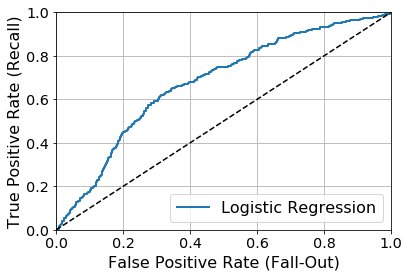

In [43]:
plot_roc_curve(fpr_lg, tpr_lg, "Logistic Regression")
plt.legend(loc="lower right", fontsize=16)
plt.show();

In [45]:
from sklearn.metrics import roc_auc_score

roc_auc_score(train_labels, y_scores_lg)

0.67748857142857133

### Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

forest_cls = RandomForestClassifier(random_state=42)

In [54]:
y_probas_forest = cross_val_predict(forest_cls, train_reduced, train_labels, method='predict_proba', cv=5)

In [55]:
y_scores_forest = y_probas_forest[:, 1] #prob for positive class
fpr_forest, tpr_forest, thesholds_forest = roc_curve(train_labels, y_scores_forest)

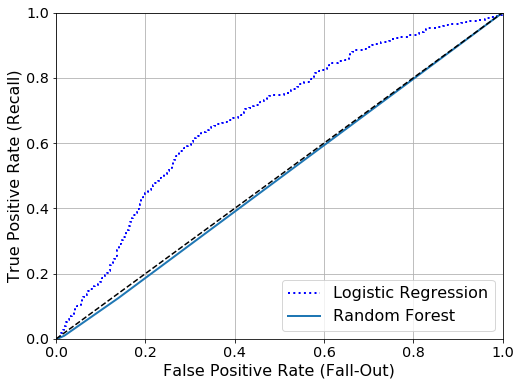

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lg, tpr_lg, "b:", linewidth=2, label="Logistic Regression")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show();

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5)
y_probas_knn = cross_val_predict(knn_clf, train_reduced, train_labels, method='predict_proba', cv=5)
y_scores_knn = y_probas_knn[:, 1] #prob for positive class
fpr_knn, tpr_knn, thesholds_knn = roc_curve(train_labels, y_scores_knn)

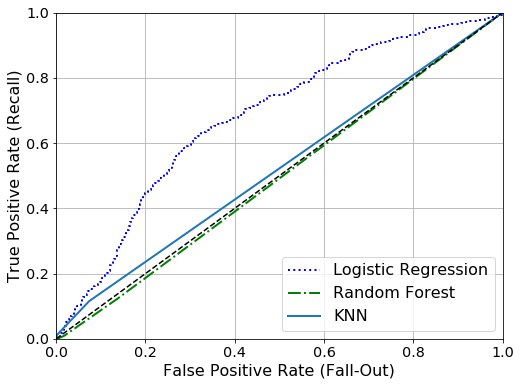

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lg, tpr_lg, "b:", linewidth=2, label="Logistic Regression")
plt.plot(fpr_forest, tpr_forest, "g-.", linewidth=2, label="Random Forest")
plot_roc_curve(fpr_knn, tpr_knn, "KNN")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show();

### SVM

In [62]:
from sklearn.svm import SVC

svm_clf = SVC(class_weight={0: .1, 1: .9}, random_state=42, C=.6, probability=True)
y_probas_svm = cross_val_predict(svm_clf, train_reduced, train_labels, method='predict_proba', cv=3)
y_scores_svm = y_probas_svm[:, 1] #prob for positive class
fpr_svm, tpr_svm, thesholds_svm = roc_curve(train_labels, y_scores_svm)

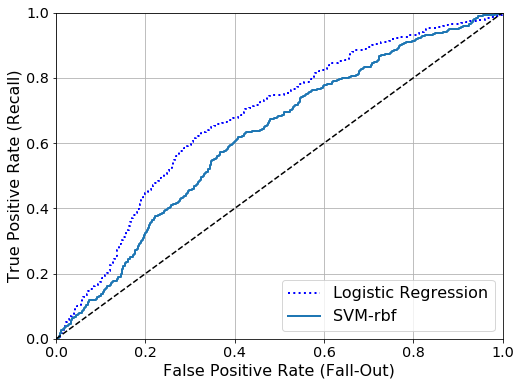

In [63]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lg, tpr_lg, "b:", linewidth=2, label="Logistic Regression")
plot_roc_curve(fpr_svm, tpr_svm, "SVM-rbf")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show();

### Boosting Algorithms

* xgboost

In [24]:
import xgboost as xgb
from xgboost import XGBClassifier

def xgb_classifier(X_train, X_test, y_train, y_test, useTrainCV=True, plot_features=False, cv_folds=5, early_stopping_rounds=50):
    
    alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    # training
    print('Start Training')
    alg.fit(X_train, y_train, eval_metric='auc')
 
    # predict
    print("Start Predicting")
    predictions = alg.predict(X_test)
    pred_proba = alg.predict_proba(X_test)[:, 1]

    # auc score
    print("AUC: %f" % roc_auc_score(y_test, pred_proba))
    
    if plot_features:

        feat_imp = alg.feature_importances_
        feat = X_train.columns.tolist()

        res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
        res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()
        print(res_df)
        print(res_df["Features"].tolist())
    return pred_proba

In [81]:
X_train, X_test, y_train, y_test = train_test_split(train_reduced, train_labels, test_size=0.33, random_state=42)
y_scores_xgb = xgb_classifier(X_train, X_test, y_train, y_test)

Start Feeding Data
Start Training
Start Predicting
AUC: 0.500000


other way of preprocessing:
1. after missing value is handled, do not scale; instead use catboostencoder to convert the data

2. oversampling minority class


Train on encoded features, no scaling. Features are those not in `colsunused.csv`.

In [78]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.33, random_state=42)
print(f'Shape of train set: {X_train.shape}')
print(f'Shape of val set: {X_val.shape}')

Shape of train set: (17801, 224)
Shape of val set: (8769, 224)


In [79]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

start = time.time()
imputer.fit(X_train)
train_cpl = imputer.transform(X_train)
test_cpl = imputer.transform(X_val)
end = time.time()
print(f'Used {end-start:.2f} seconds.')

Used 0.62 seconds.


In [80]:
cat_cols = X_train.columns.values

from category_encoders.cat_boost import CatBoostEncoder

encoder = CatBoostEncoder(cols=cat_cols)

train_ = pd.DataFrame(train_cpl, columns=X_train.columns)
val_ = pd.DataFrame(test_cpl, columns = X_val.columns)

encoder.fit(train_, y_train)
X_train_enc = encoder.transform(train_)
X_val_enc = encoder.transform(val_)

In [81]:
codetonan(test_set, unknown_code)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Total execution time of this procedure: 22.76 seconds


In [82]:
encoded_test = encode_df(test_set)

/home/workspace/Arvato_Customer_Segmentation/utils/preprocess.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].apply(lambda x: strtoint(x) if x is not np.nan else x)
/home/workspace/Arvato_Customer_Segmentation/utils/preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['CAMEO_DEUG_2015']= df['CAMEO_DEUG_2015'].astype('float64')
/home/workspace/Arvato_Customer_Segmentation/utils/preprocess.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [83]:
X_test = encoded_test.drop(['RESPONSE', 'LNR']+to_drop, axis=1)
y_test = encoded_test['RESPONSE']

X_test_imp = imputer.transform(X_test)
X_test_imp = pd.DataFrame(X_test_imp, columns=X_test.columns)
X_test_enc = encoder.transform(X_test_imp)

#### Training models with catboost encoded features

In [135]:
from sklearn.linear_model import LogisticRegression

log_cls_lf = LogisticRegression(class_weight={0: .1, 1: .9},
                            random_state=42)

y_probas_lglf = cross_val_predict(log_cls_lf, X_train_enc, y_train, method='predict_proba', cv=5)

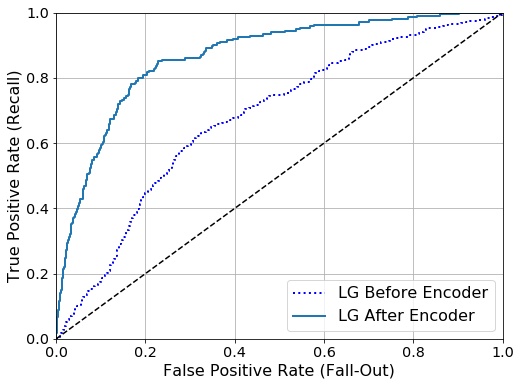

In [138]:
y_scores_lglf = y_probas_lglf[:, 1] #prob for positive class
fpr_lglf, tpr_lglf, thesholds_lglf = roc_curve(y_train, y_scores_lglf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lg, tpr_lg, "b:", linewidth=2, label="LG Before Encoder")
plot_roc_curve(fpr_lglf, tpr_lglf, "LG After Encoder")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show();

In [140]:
roc_auc_score(y_train, y_scores_lglf)

0.86626804314359218

### Gradientboosting classifier

In [29]:
y_scores_xgb = xgb_classifier(X_train_enc, X_val_enc, y_train, y_val)

Start Feeding Data
Start Training
Start Predicting
AUC: 0.787406


In [32]:
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [38]:
class_weight={0: .1, 1: .9}

logreg = LogisticRegression(class_weight=class_weight, random_state=42)
svc = SVC(class_weight=class_weight, probability=True)
knn = KNeighborsClassifier(n_neighbors=5)

class_list = [logreg, svc, knn]
#random = RandomForestClassifier(random_state=42)
#gbc = GradientBoostingClassifier()
#mlp = MLPClassifier(activation='logistic')

In [39]:
for model in class_list:
    time_0 = time.time()
    grid = GridSearchCV(estimator=model, param_grid={}, scoring='roc_auc', cv=5, n_jobs=-1)
    grid.fit(X_train_enc, y_train)
    time_1 = time.time()
    print(model, grid.best_score_, round(time_1-time_0))

LogisticRegression(C=1.0, class_weight={0: 0.1, 1: 0.9}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 0.869081480354 2
SVC(C=1.0, cache_size=200, class_weight={0: 0.1, 1: 0.9}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.894101098582 494
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') 0.601597221974 773


Best model is SVM, with score: 0.894.

In [48]:
#svc = SVC(class_weight=class_weight, probability=True)

svm_clf = SVC(class_weight={0: .1, 1: .9}, random_state=42, C=.6, probability=True)
svm_clf.fit(X_train_enc, y_train)

SVC(C=0.6, cache_size=200, class_weight={0: 0.1, 1: 0.9}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

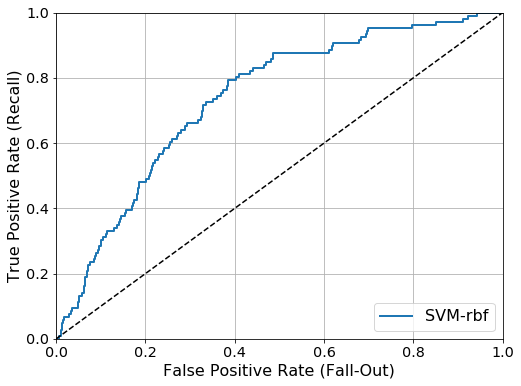

In [54]:
from sklearn.metrics import roc_curve

y_proba_svm = svm_clf.predict_proba(X_val_enc)
y_scores_svm = y_proba_svm[:, 1] #prob for positive class
fpr_svm, tpr_svm, thesholds_svm = roc_curve(y_val, y_scores_svm)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_svm, tpr_svm, "SVM-rbf")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show();

In [56]:
roc_auc_score(y_val, y_scores_svm)

0.73569441933706359

change params

In [83]:
param_grid = {'C': [0.6, 0.7, 0.9, 1],
             'degree': [2, 3]}

clf = SVC(class_weight={0: .1, 1: .9}, random_state=42, probability=False)

best = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
best.fit(X_train_enc, y_train)

print(best.best_score_,best.best_estimator_)

0.888448877458 SVC(C=1, cache_size=200, class_weight={0: 0.1, 1: 0.9}, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


In [85]:
model = best.best_estimator_

proba = np.array(model.decision_function(X_test_enc))
roc_auc_score(y_test, proba)

0.66449227011292411

logistic regression

In [88]:
logreg = LogisticRegression(class_weight=class_weight, random_state=42)
logreg.fit(X_train_enc, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.1, 1: 0.9}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [89]:
proba = logreg.predict_proba(X_test_enc)[:, 1]
roc_auc_score(y_test, proba)

0.6963258648811057

xgboost

In [91]:
alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

alg.fit(X_train_enc, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1.0, gamma=0.2, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=nan, monotone_constraints=None,
       n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
       objective='binary:logistic', random_state=27, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.6,
       tree_method=None, validate_parameters=False, verbosity=None)

In [92]:
proba = alg.predict_proba(X_test_enc)[:, 1]
roc_auc_score(y_test, proba)

0.68127726531344868

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neural_network import MLPClassifier
class_weight={0: .1, 1: .9}

gb = GradientBoostingClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100,oob_score=True,max_features=5)
#mpl = MLPClassifier(activation='logistic')

class_list = [gb, rf]
fr = []
tr = []
thr = []
for model in class_list:
    train_proba = cross_val_predict(model, X_train_enc, y_train, method='predict_proba', cv=5)
    train_scores = train_proba[:, 1] #prob for positive class
    fpr, tpr, thesholds = roc_curve(y_train, train_scores)
    auc_score = roc_auc_score(y_train, train_scores)
    fr.append(fpr)
    tr.append(tpr)
    thr.append(thesholds)
    print(model)
    print(auc_score)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.833373100033
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
       

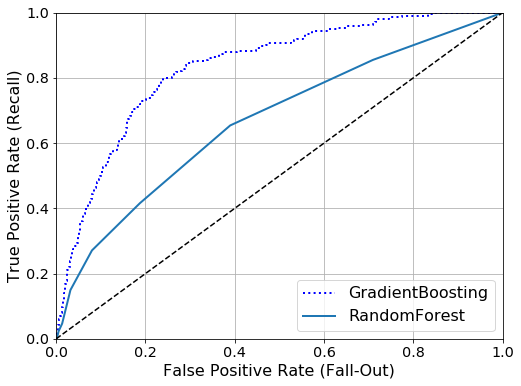

In [38]:
plt.figure(figsize=(8, 6))

plt.plot(fr[0], tr[0], "b:", linewidth=2, label="GradientBoosting")
plot_roc_curve(fr[1], tr[1], "RandomForest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show();

In [40]:
param_grid = {'max_depth': [3,4,5],
             'loss':['deviance', 'exponential'],
             'n_estimators': [100, 150, 200]}

best = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
best.fit(X_train_enc, y_train)

print(best.best_score_,best.best_estimator_)

0.855963336665 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [42]:
best.best_params_

{'loss': 'exponential', 'max_depth': 3, 'n_estimators': 200}

In [41]:
model = best.best_estimator_

proba = model.predict_proba(X_test_enc)[:, 1]
roc_auc_score(y_test, proba)

0.69475140277355063

### Use smote to oversample the minority class

In [84]:
from collections import Counter

print('Original dataset shape %s' % Counter(y_train))
sm = SMOTE(.3, random_state=42)
X_res, y_res = sm.fit_resample(X_train_enc, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 17587, 1: 214})
Resampled dataset shape Counter({0: 17587, 1: 5276})


Try the classes again

In [ ]:
gb_sm = GradientBoostingClassifier(random_state=42, loss='exponential', max_depth=3, n_estimators=200) #more params
train_proba = cross_val_predict(gb_sm, X_res, y_res, method='predict_proba', cv=5)
train_scores = train_proba[:, 1] #prob for positive class

fpr, tpr, thesholds = roc_curve(y_res, train_scores)
auc_score = roc_auc_score(y_res, train_scores)
#auc_score

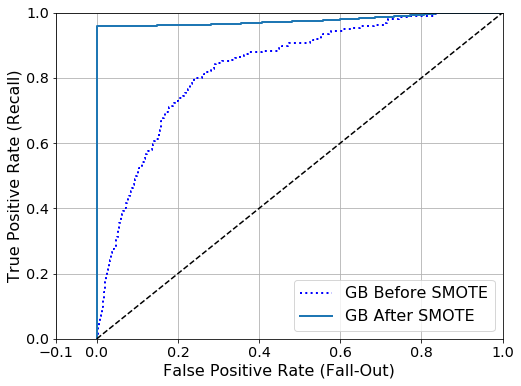

In [52]:
plt.figure(figsize=(8, 6))

plt.plot(fr[0], tr[0], "b:", linewidth=2, label="GB Before SMOTE")
plot_roc_curve(fpr, tpr, "GB After SMOTE")
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show();

In [86]:
gb_sm.fit(X_res, y_res)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

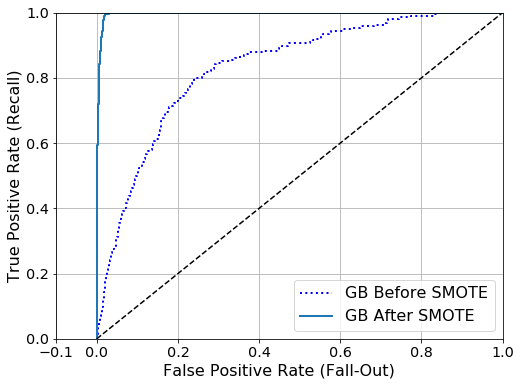

In [87]:
y_proba_gb_sm= gb_sm.predict_proba(X_train_enc)
y_scores_gb_sm = y_proba_gb_sm[:, 1] #prob for positive class
fpr_gbsm, tpr_gbsm, thesholds_gbsm= roc_curve(y_train, y_scores_gb_sm)

plt.figure(figsize=(8, 6))

plt.plot(fr[0], tr[0], "b:", linewidth=2, label="GB Before SMOTE")
plot_roc_curve(fpr_gbsm, tpr_gbsm, "GB After SMOTE")
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show();

In [89]:
y_proba_gb_sm= gb_sm.predict_proba(X_val_enc)
y_scores_gb_sm = y_proba_gb_sm[:, 1] #prob for positive class
roc_auc_score(y_val, y_scores_gb_sm)

0.75727285201213568

In [90]:
proba = gb_sm.predict_proba(X_test_enc)[:, 1]
roc_auc_score(y_test, proba)

0.71153005720350571

## Visualize the model

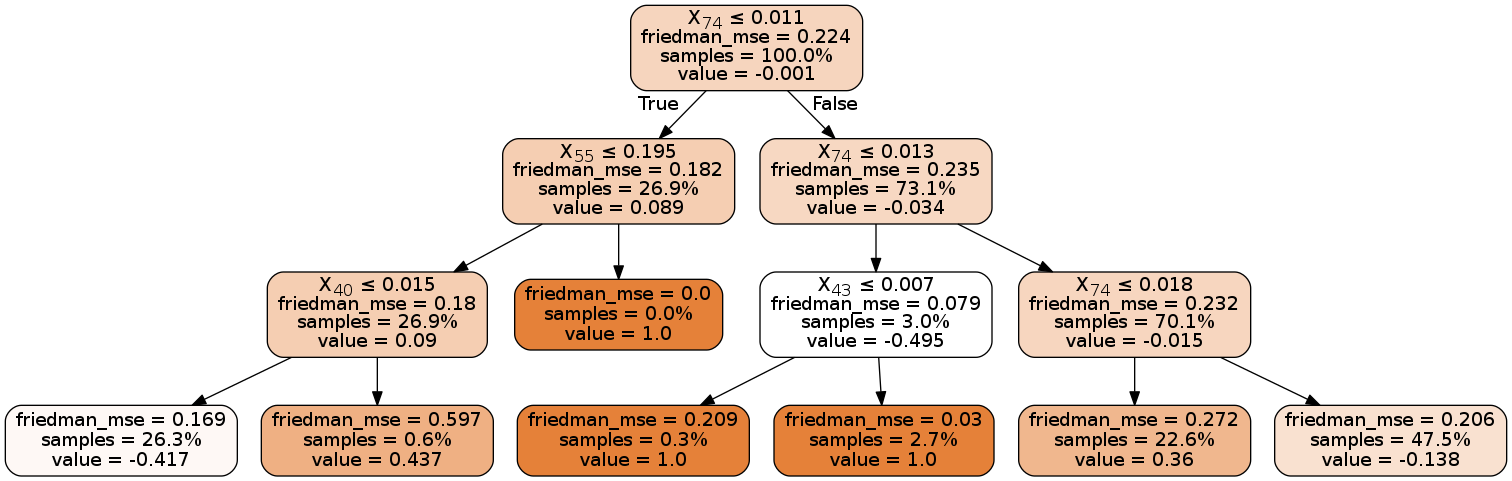

In [62]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# Get the tree number 42
sub_tree_42 = gb_sm.estimators_[42, 0]

dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True,
    rounded=True,  
    special_characters=True,
    proportion=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [9]:
cols_ind = [74, 55, 43, 40]
X_train.iloc[:, cols_ind].columns

Index(['KBA05_ALTER1', 'D19_VERSI_ONLINE_DATUM', 'D19_SOZIALES',
       'D19_SAMMELARTIKEL'],
      dtype='object')

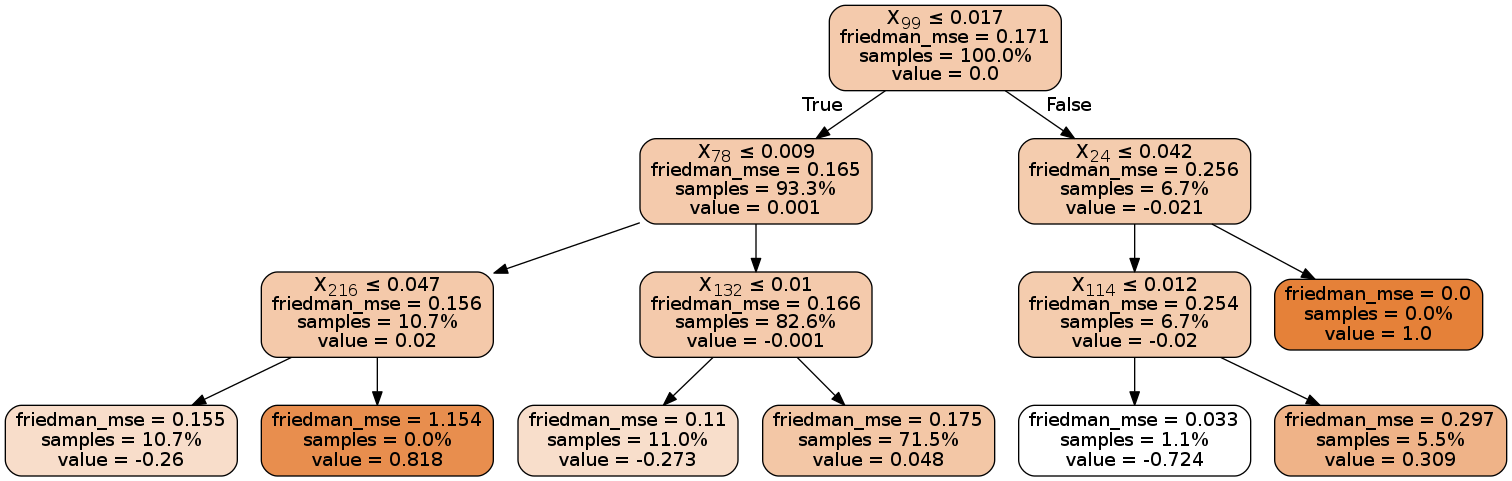

In [64]:
# Get the tree number 199
sub_tree_199 = gb_sm.estimators_[199, 0]

dot_data = export_graphviz(
    sub_tree_199,
    out_file=None, filled=True,
    rounded=True,  
    special_characters=True,
    proportion=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [10]:
cols_ind = [99, 78, 24, 216, 132, 114]
X_train.iloc[:, cols_ind].columns

Index(['KBA05_KW2', 'KBA05_ANHANG', 'D19_DIGIT_SERV', 'VERDICHTUNGSRAUM',
       'KBA13_CCM_1800', 'KBA05_SEG8'],
      dtype='object')

I found [this article](https://stackoverflow.com/questions/50111612/confused-by-apply-function-of-gradientboostingclassifier) explains quite well on the visualisation.

## Submit to Kaggle

In [111]:
submission = mailout_test[['LNR']]
codetonan(mailout_test, unknown_code)

Total execution time of this procedure: 0.28 seconds


In [112]:
subm_cleaned = encode_df(mailout_test)
subm_reduced = subm_cleaned.drop(to_drop+['LNR'], axis=1)
subm_imp = imputer.transform(subm_reduced)
subm_imp = pd.DataFrame(subm_imp, columns=subm_reduced.columns)
subm_enc = encoder.transform(subm_imp)

In [113]:
subm_enc.shape

(42833, 224)

In [114]:
X_train_enc.shape

(17801, 224)

In [117]:
model = gb_sm

subm_prob = model.predict_proba(subm_enc)[:, 1]

In [118]:
submission['RESPONSE'] = subm_prob

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [119]:
submission.head()

,LNR,RESPONSE
0,1754,0.000620
1,1770,0.000842
2,1465,0.000470
3,1470,0.000320
4,1478,0.000041


In [120]:
submission.to_csv('ailing_submissiong.csv', header=True, index=False)

In [121]:
submission.shape

(42833, 2)

Kaggle score: .73, position 102.